# Test

## 1. Transformers

Testing the usage instructions from https://huggingface.co/transformers/task_summary.html

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

result = classifier("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

result = classifier("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

In [ ]:
from transformers import pipeline

ner_pipe = pipeline("ner")

sequence = """Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO,
therefore very close to the Manhattan Bridge which is visible from the window."""

In [ ]:
print(ner_pipe(sequence))

In [ ]:
from transformers import TFAutoModelForTokenClassification, AutoTokenizer
import tensorflow as tf

model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
           "close to the Manhattan Bridge."

# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="tf")

outputs = model(inputs)[0]
predictions = tf.argmax(outputs, axis=2)

In [ ]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

## 2. BERT

Testing instructions from https://huggingface.co/transformers/model_doc/bert.html

There are two groups of BERT modules. The standard one (BERT) uses PyTorch but we need the transformers version (TFBERT). 

In [ ]:
from transformers import BertTokenizer, TFBertForTokenClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForTokenClassification.from_pretrained('bert-base-cased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
input_ids = inputs["input_ids"]
inputs["labels"] = tf.reshape(tf.constant([1] * tf.size(input_ids).numpy()), (-1, tf.size(input_ids))) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

In [ ]:
logits

In [ ]:
outputs

In [ ]:
inputs

## 3. BERTje

Instructions: https://huggingface.co/GroNLP/bert-base-dutch-cased

Alternative models used by Bouma 2021: RobBERT (Delobelle), mBERT (Google), XLM-R (Conneau)

BERTje paper also mentions BERT-NL (textdata.nl)

In [ ]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow

In [ ]:
tokenizer.tokenize("Dit is een test.")

These instructions could be useful: 
* https://www.tensorflow.org/text/tutorials/classify_text_with_bert
* https://www.tensorflow.org/official_models/fine_tuning_bert

Even more: https://duckduckgo.com/?q=bert+tensorflow+text+classification

### 3.1 IMDB data set

Instructions: https://www.tensorflow.org/tutorials/keras/text_classification

In [ ]:
import os
import re
import shutil
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

FATAL ERROR!

### 3.2 Sentiment analysis

Instructions: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2021-07-22 10:44:20.473304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-22 10:44:20.473339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Load IMDB data (skip)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Load social distancing data

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
DATA_DIR = 'social_distancing_relevance'

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    DATA_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    DATA_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 5977 files belonging to 2 classes.
Using 4782 files for training.


2021-07-22 10:44:27.435714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-22 10:44:27.435743: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-22 10:44:27.435774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eslt0070): /proc/driver/nvidia/version does not exist
2021-07-22 10:44:27.436496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5977 files belonging to 2 classes.
Using 1195 files for validation.


In [3]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b'RT @renevanm: Niet knuffelen, geen seks, 2 meter afstand houden... ik zit blijkbaar al geruime tijd in quarantaine.\n'
Label : 1 (RELEVANT)
Review: b'@Witty966 Ze volgen de onderzoeken niet of willen het niet weten!\\n\\n1.5 meter afstand helpt niets wanneer niet wordt geventileerd!\\n\\nhttps://t.co/u8Ga2Kpuoy\n'
Label : 1 (RELEVANT)
Review: b'@iOnAsJ @slecluyse @GeertNoels @Stijn_Baert ja inderdaad, gisteren dochter, echtgenoot, kleinkind thuis ontvangen, anderhalve meter? dat kon gewoonweg niet, meteen mondmasker aangedaan en ontsmettingsgel erbij genomen, maw...  zo was het niet gezellig. We gaan vrijwillig terug naar oude situatie. buiten aan de deur dus.\n'
Label : 1 (RELEVANT)


2021-07-22 10:44:28.764990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-22 10:44:28.785081: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz
2021-07-22 10:44:28.826286: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


This is the place where the BERT model is selected. There are mainly English language models available with one multi-lingual model which crashes the machine. No working Dutch models are found at the related website.   

In [4]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'wiki40b-lm-nl':
        'https://tfhub.dev/google/wiki40b-lm-nl/1',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'wiki40b-lm-nl':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [6]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 10531 10124 11049 10151 28149 19308 18379   106   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [8]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.6052361  -0.03562833  0.34877217 -0.41043743 -0.39114502  0.52867943
  0.4629631   0.08782487 -0.47338453  0.35345632 -0.06693023 -0.27646577]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.33073407  0.14612621 -0.06266934 ...  0.84484535 -0.12296543
   0.77432895]
 [-0.8536666  -0.01048076 -0.10002846 ...  0.4412018  -0.23505431
   0.6783054 ]
 [-0.7773089   0.40002573 -0.17473161 ...  0.7971061  -0.21617687
   0.8154314 ]
 ...
 [-0.53897893  0.20686042  0.33575624 ...  0.5694974  -0.24205497
   0.53376555]
 [-0.5707657   0.10813653  0.18492147 ...  0.8677025  -0.16494572
   0.56380117]
 [-0.56603634  0.1004438   0.17902762 ...  0.80625296 -0.11992311
   0.53856736]]


In [9]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [10]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.508649]], shape=(1, 1), dtype=float32)


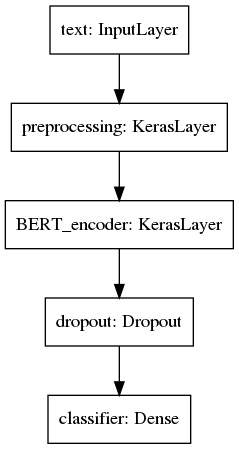

In [11]:
tf.keras.utils.plot_model(classifier_model)

In [12]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [13]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

This takes a lot of time (5 hours for imdb data), so skip it

In [15]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/5
 60/150 [===========>..................] - ETA: 58:22 - loss: 0.5954 - binary_accuracy: 0.6245

KeyboardInterrupt: 

Results for social distancing data on training data:

| type | classes | 1 | 2 | 3 | 4 | 5 |
| -- | -- | -- | -- | -- | -- | -- |
| bert_en_uncased_L-12_H-768_A-12  | 3 | 0.550 | 0.565 | 0.580 | 0.580 | 0.587 |
| bert_multi_cased_L-12_H-768_A-12 | 3 | 0.536 | 0.554 | 0.571 | 0.599 | 0.616  |
| bert_multi_cased_L-12_H-768_A-12 | 2 | 0.791 | 0.797 | 0.843 | | |

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'social_distancing'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Resume processing here:

In [ ]:
dataset_name = 'social_distancing'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'iedereen moet afstand houden',  # this is the same sentence tried earlier
    'hou afstand',
    'niemand houdt afstand',
    'de afstand tot het doel is 11 meter',
    'ze moeten stoppen met maatregelen als 1,5 m'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
# original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
# print('Results from the model in memory:')
# print_my_examples(examples, original_results)

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

### 3.3 Prepare data for tensorflow

In [ ]:
import os
import pandas as pd

In [ ]:
DATA_DIR_IN = "../../puregome/data/annotation/"
TEXT_FILE = os.path.join(DATA_DIR_IN, "distance-tweets.csv")
LABEL_FILE = TEXT_FILE + ".human-labels.txt"
DATA_DIR_OUT = "social_distancing/"

In [ ]:
def extract_data(text_df, label_df):
    data_dict = {}
    target_annotator = ""
    for i, row in label_df.iterrows():
        if target_annotator == "":
            target_annotator = row["annotator"]
        if row["id_str"] in text_df.index and row["annotator"] == target_annotator:
            data_dict[row["id_str"]] = { "label": row["label"], "text": text_df.loc[row["id_str"]]["text"] }
    return data_dict

In [ ]:
def store_data(data_dict):
    for id_str in data_dict:
        out_dir = os.path.join(DATA_DIR_OUT, data_dict[id_str]["label"])
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        out_file = open(os.path.join(out_dir, str(id_str) + ".txt"), "w")
        print(data_dict[id_str]["text"], file=out_file)
        out_file.close()

In [ ]:
text_df = pd.read_csv(TEXT_FILE, index_col="id_str")
label_df = pd.read_csv(LABEL_FILE, sep=" ", header=None, names=["annotator", "date", "id_str", "data_set_id", "label"])
data_dict = extract_data(text_df, label_df)

In [ ]:
len(data_dict)

This stores the tweets in subdirectories of `social_distancing` where the names of the subdirectories are equal to the labels and where each tweet is stored in a file named `id_str.txt`

In [ ]:
store_data(data_dict)

## 4. ROBBERT

Instructions: https://huggingface.co/pdelobelle/robbert-v2-dutch-base and https://github.com/iPieter/RobBERT

Requires PyTorch: https://pytorch.org/<br>
Installation command (select: pip & CPU): `pip3 install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html`

In [19]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classif

In [23]:
inputs = tokenizer("Mijn hond is schattig", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0) # Batch size 1
outputs = model(**inputs)
loss = outputs.loss
logits = outputs.logits

In [24]:
inputs

{'input_ids': tensor([[    0,  1840,  1671,    12, 12223,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [25]:
logits

tensor([[0.2427, 0.1934]], grad_fn=<AddmmBackward>)

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [3]:
logits


tensor([[ 0.1636, -0.0760]], grad_fn=<AddmmBackward>)

In [16]:
tokenizer("Dit is een test!")['input_ids']

[0, 495, 405, 16, 364, 225, 1296, 328, 2]

In [19]:
tokenizer.decode([0, 495, 405, 16, 364, 225, 1296, 328, 2])

'<s>Dit is een test!</s>'

In [20]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')

inputs = tokenizer("The capital of France is <mask>.", return_tensors="pt")
labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [21]:
logits

tensor([[[34.8744, -3.8884, 18.9567,  ...,  2.8639,  5.2812, 11.2557],
         [ 8.5224, -2.9420, 19.8858,  ...,  2.7513,  4.0812,  8.5191],
         [-3.2755, -4.2489,  9.6843,  ..., -1.3403, -2.0838, -0.4035],
         ...,
         [-4.8167, -3.8881,  8.3117,  ..., -4.3991, -5.6916,  1.1575],
         [20.6686, -4.4710, 20.3602,  ...,  0.9624,  3.1282,  7.1575],
         [11.6269, -3.6408, 32.1565,  ...,  2.0802, -0.2959,  9.1577]]],
       grad_fn=<AddBackward0>)

## 5. BERT Fine-Tuning Tutorial with PyTorch

Python code source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, BertTokenizer, BertForSequenceClassification
import torch
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2021-07-23 17:27:09.658604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-23 17:27:09.658626: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_DIR = "social_distancing"


def read_text_file(file_name):
    text_file = open(file_name, "r")
    text = ""
    for line in text_file.read():
        text += line
    text_file.close()
    return text


def read_data(data_dir):
    data = []
    label_values = {'ONEENS': 0, 'EENS': 0, 'ANDERS': 1}
    for label in os.listdir(data_dir):
        label_dir = os.path.join(DATA_DIR, label)
        if label not in label_values:
            label_values[label] = len(label_values)
        for id_file_name in os.listdir(label_dir):
            data.append({"text": read_text_file(os.path.join(label_dir, id_file_name)),
                         "label": label_values[label],
                         "id": re.sub(".txt$", "", id_file_name) })
    data = sorted(data, key=lambda item: item["id"])
    return [data, label_values]

In [3]:
data, label_values = read_data(DATA_DIR)
sentences = [ item["text"] for item in data ]
file_labels = [ item["label"] for item in data ]

In [4]:
num_labels = len(set(label_values.values()))

tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", 
                                                         num_labels = num_labels)

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.weight', 'class

In [5]:
def remove_initial_words(sentence, n):
    words = sentence.strip().split()
    return " ".join(words[int(n):])

In [6]:
input_ids = []
attention_masks = []
expanded_labels = []
max_length = 64

for i in range(0, len(sentences)):
    sentence = sentences[i]
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        max_length = max_length,
                        truncation=True,
                        pad_to_max_length = True,
                        add_special_tokens = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    if encoded_dict['attention_mask'][0][max_length-1] == 0:
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        expanded_labels.append(file_labels[i])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(expanded_labels)

# Print sentence 0, now as a list of IDs.
print(f"Kept: {len(input_ids)} of {len(sentences)}")
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/home/erikt/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Kept: 3367 of 5977
Original:  Ventus W830\n8h | Actueel weer\n\nWind: 1.3 m/s\nWindvlaag: 1.5 m/s\nTemperatuur: 10.8 °C\nRel. vochtigheid: 94 %\nLuchtdruk: 987.4 hPa\nRegen: 0.0 mm\nZon-instraling: 0 W/m²\nUV index: 0 \n\nhttps://t.co/NxSdjQygYA\n#Weathercloud

Token IDs: tensor([    0,   557,   967,  1091,   327,    15,   705,    82,     6,   246,
         2959,   110,  2486,     6,  6214,  6151,     7,     5,  2226, 10705,
         7828,  2033,     7,    93,     6,   648,  2959,   153,  3314,     8,
        31577,     4,  3551,  1321,   127,     4,  1178,    68,   342,   119,
          403,   348,   283,   298,   348,   287,   648,   501, 39987,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


In [7]:
from torch.utils.data import TensorDataset, random_split

train_end = int(0.8 * len(input_ids))
validation_end = int(0.9 * len(input_ids))
train_dataset = TensorDataset(input_ids[:train_end], attention_masks[:train_end], labels[:train_end])
val_dataset = TensorDataset(input_ids[train_end:validation_end], attention_masks[train_end:validation_end], labels[train_end:validation_end])
test_dataset = TensorDataset(input_ids[validation_end:], attention_masks[validation_end:], labels[validation_end:])

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))
print('{:>5,} test samples'.format(len(test_dataset)))

2,693 training samples
  337 validation samples
  337 test samples


In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [9]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [10]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [11]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
device = torch.device("cpu")

In [14]:
import random
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        model.zero_grad()        
        model_output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            model_output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    10  of     85.    Elapsed: 0:01:40.
  Batch    20  of     85.    Elapsed: 0:03:27.
  Batch    30  of     85.    Elapsed: 0:05:06.
  Batch    40  of     85.    Elapsed: 0:06:39.
  Batch    50  of     85.    Elapsed: 0:08:17.
  Batch    60  of     85.    Elapsed: 0:09:57.
  Batch    70  of     85.    Elapsed: 0:11:36.
  Batch    80  of     85.    Elapsed: 0:13:22.

  Average training loss: 0.55
  Training epoch took: 0:14:09

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.57
  Validation took: 0:00:36

======== Epoch 2 / 4 ========
Training...
  Batch    10  of     85.    Elapsed: 0:01:45.
  Batch    20  of     85.    Elapsed: 0:03:26.
  Batch    30  of     85.    Elapsed: 0:05:09.
  Batch    40  of     85.    Elapsed: 0:06:50.
  Batch    50  of     85.    Elapsed: 0:08:39.
  Batch    60  of     85.    Elapsed: 0:10:24.
  Batch    70  of     85.    Elapsed: 0:12:02.
  Batch    80  of     85.    Elapsed: 0:13:45.

  Averag

In [15]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.55,0.57,0.72,0:14:09,0:00:36
2,0.47,0.57,0.70,0:14:26,0:00:36
3,0.40,0.60,0.71,0:14:45,0:00:32
4,0.34,0.61,0.71,0:13:45,0:00:32


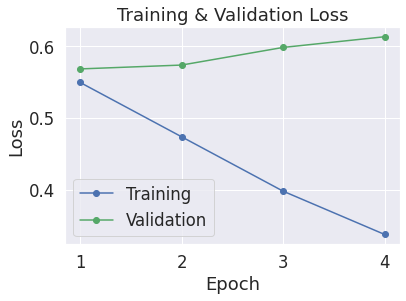

In [16]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks()
plt.show()

In [17]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

model.eval()
predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 337 test sentences...
    DONE.


In [18]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
prediction_labels = []
print('Calculating Matthews Corr. Coef. for each batch...')
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    prediction_labels.extend(pred_labels_i)
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/home/erikt/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


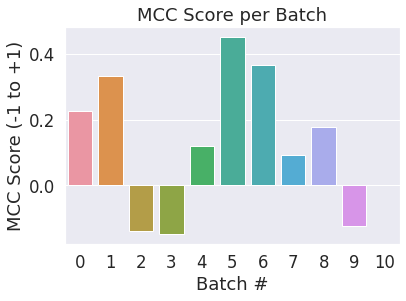

In [19]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

In [20]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: 0.143


In [21]:
true_labels_flattened = []
for array in true_labels:
    true_labels_flattened.extend(array)
print(label_values)
confusion_matrix(true_labels_flattened, prediction_labels)

{'ONEENS': 0, 'EENS': 0, 'ANDERS': 1}


array([[212,  36],
       [ 65,  24]])

Confusion matrix for three-label task:
<pre>
{'ONEENS': 0, 'EENS': 1, 'ANDERS': 2}

array([[ 50,  41,  22],
       [ 13, 106,  16],
       [ 10,  56,  23]])
</pre>

### 5.1 To do

1. testing on all data including tweets of more than mac_length-2 tokens
2. 10-cv test
3. showing validation accuracy during run